# Poisson Regression (PoissonReg) Example

This is a SIMPLE sample implementation of Poisson Regression using the `turtles` `PoissonReg` class and various supporting functions.

The `PoissonReg` class implements Poisson Regression using Maximum Likelihood Estimation (MLE) for parameter estimation.

This demo (kind-of) replicates this Scikit Learn example: https://scikit-learn.org/stable/auto_examples/linear_model/plot_poisson_regression_non_normal_loss.html#sphx-glr-auto-examples-linear-model-plot-poisson-regression-non-normal-loss-py

In [1]:
import statsmodels.api as sm
from sklearn.datasets import fetch_openml

from turtles.stats.glms import PoissonReg
from turtles.preprocess import one_hot_encode

In [2]:
# get insurance claims data
df = fetch_openml(data_id=41214, as_frame=True).frame

# shorten dataset
df = df.iloc[:5000]

print(df.shape)
df.head(10)

(5000, 12)


,IDpol,ClaimNb,Exposure,Area,VehPower,VehAge,DrivAge,BonusMalus,VehBrand,VehGas,Density,Region
0,1.0,1,0.10,D,5,0,55,50,B12,'Regular',1217,R82
1,3.0,1,0.77,D,5,0,55,50,B12,'Regular',1217,R82
2,5.0,1,0.75,B,6,2,52,50,B12,'Diesel',54,R22
3,10.0,1,0.09,B,7,0,46,50,B12,'Diesel',76,R72
4,11.0,1,0.84,B,7,0,46,50,B12,'Diesel',76,R72
5,13.0,1,0.52,E,6,2,38,50,B12,'Regular',3003,R31
6,15.0,1,0.45,E,6,2,38,50,B12,'Regular',3003,R31
7,17.0,1,0.27,C,7,0,33,68,B12,'Diesel',137,R91
8,18.0,1,0.71,C,7,0,33,68,B12,'Diesel',137,R91
9,21.0,1,0.15,B,7,0,41,50,B12,'Diesel',60,R52


<Axes: >

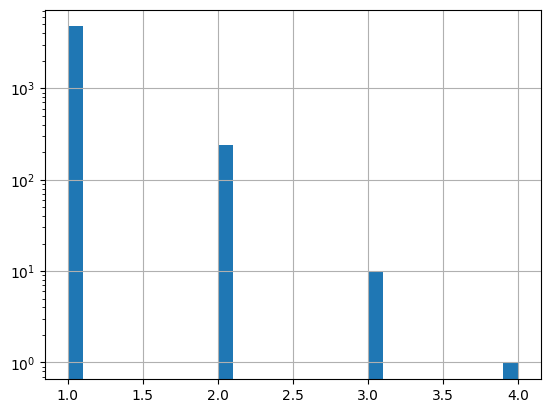

In [3]:
# approximately poisson???
df["ClaimNb"].hist(bins=30, log=True)

In [4]:
# in this demo, we'll just use some of the categorical features
df = df[["ClaimNb", "Exposure", "Area", "VehBrand"]].copy()
df.shape

(5000, 4)

In [5]:
# encode all categorical variables
df_enc = one_hot_encode(df, ["Area", "VehBrand"])
print(df_enc.shape)
df_enc.head()

(5000, 17)


,ClaimNb,Exposure,Area_B,Area_C,Area_D,Area_E,Area_F,VehBrand_B10,VehBrand_B11,VehBrand_B12,VehBrand_B13,VehBrand_B14,VehBrand_B2,VehBrand_B3,VehBrand_B4,VehBrand_B5,VehBrand_B6
0,1,0.10,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0
1,1,0.77,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0
2,1,0.75,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0
3,1,0.09,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0
4,1,0.84,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0


In [6]:
# separate X and y
X = df_enc.drop(columns=["ClaimNb"])
y = df_enc["ClaimNb"]

print(X.shape)
print(y.shape)

(5000, 16)
(5000,)


In [7]:
# extract exposure
exposure = X["Exposure"]
X = X.drop(columns=["Exposure"])

print(X.shape)
print(exposure.shape)

(5000, 15)
(5000,)


In [8]:
# convert to numpy
X = X.to_numpy()
exposure = exposure.to_numpy().reshape(exposure.shape[0], 1)
y = y.to_numpy().reshape(y.shape[0], 1)

print(X.shape)
print(exposure.shape)
print(y.shape)

(5000, 15)
(5000, 1)
(5000, 1)


In [9]:
# fit model using newton's method
n_model = PoissonReg(
    method="newton",
    learning_rate=0.01
)
n_model.fit(
    X, 
    y, 
    exposure
)

print(n_model.summary())
print()
print("Iterations:", n_model.iterations)

     Variable  Coefficient  Std Error  z-statistic  p-value  [0.025  0.075]
0   Intercept       1.1053     0.0920      12.0109   0.0000  0.9249  1.2857
1          x0       0.0393     0.0630       0.6245   0.5323 -0.0841  0.1627
2          x1       0.0195     0.0521       0.3739   0.7085 -0.0826  0.1216
3          x2       0.0397     0.0520       0.7629   0.4455 -0.0623  0.1417
4          x3       0.0378     0.0518       0.7285   0.4663 -0.0638  0.1393
5          x4       0.0483     0.0715       0.6751   0.4996 -0.0918  0.1884
6          x5      -0.3388     0.3124      -1.0845   0.2782 -0.9511  0.2735
7          x6       0.2980     0.3000       0.9931   0.3206 -0.2901  0.8861
8          x7       0.1336     0.0828       1.6144   0.1064 -0.0286  0.2958
9          x8       0.2247     0.1878       1.1961   0.2317 -0.1435  0.5928
10         x9      -0.0858     0.3439      -0.2495   0.8030 -0.7598  0.5882
11        x10       0.1218     0.1233       0.9881   0.3231 -0.1198  0.3635
12        x1

In [10]:
# fit model using l-bfgs
l_model = PoissonReg(method="lbfgs")
l_model.fit(
    X,
    y,
    exposure
)

print(l_model.summary())
print()
print("Iterations:", l_model.iterations)

     Variable  Coefficient  Std Error  z-statistic  p-value  [0.025  0.075]
0   Intercept       1.1056     0.0920      12.0168   0.0000  0.9253  1.2860
1          x0       0.0393     0.0630       0.6249   0.5320 -0.0841  0.1628
2          x1       0.0196     0.0521       0.3762   0.7067 -0.0825  0.1217
3          x2       0.0398     0.0520       0.7649   0.4443 -0.0622  0.1418
4          x3       0.0378     0.0518       0.7298   0.4655 -0.0638  0.1394
5          x4       0.0484     0.0715       0.6776   0.4980 -0.0917  0.1885
6          x5      -0.3402     0.3125      -1.0884   0.2764 -0.9527  0.2724
7          x6       0.2968     0.3001       0.9889   0.3227 -0.2915  0.8851
8          x7       0.1333     0.0827       1.6108   0.1072 -0.0289  0.2954
9          x8       0.2244     0.1878       1.1950   0.2321 -0.1437  0.5925
10         x9      -0.0824     0.3433      -0.2402   0.8102 -0.7552  0.5904
11        x10       0.1215     0.1233       0.9858   0.3242 -0.1201  0.3632
12        x1

## Compare to Statsmodels

Let's compare the `turtles` implementation to `statsmodels`.

In [11]:
import statsmodels.api as sm

X_sm = sm.add_constant(X)
poisson_model = sm.GLM(
    y.flatten(), 
    X_sm, 
    exposure=exposure.flatten(),
    family=sm.families.Poisson()
).fit()

print(poisson_model.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                 5000
Model:                            GLM   Df Residuals:                     4984
Model Family:                 Poisson   Df Model:                           15
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -7952.2
Date:                Mon, 10 Mar 2025   Deviance:                       5746.5
Time:                        17:40:22   Pearson chi2:                 1.74e+04
No. Iterations:                     6   Pseudo R-squ. (CS):           0.002768
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.1054      0.092     12.013      0.0